# Data Pipeline Example
This notebook demonstrates how data -- from the CNC machine -- can be taken from its original format (as a csv, mat, or pickle file) and then transformed into something more useful. In this case, we split the cut data up by tool number and whether or not the tool is cutting metal. Then we perform some basic feature engineering in order to build a labeled data set represent each sub-cut.

In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from pathlib import Path
import pickle

from load_data import (
    high_level_csv,
    load_cut_files,
    split_df,
    low_level_df,
    check_date    
)

from feature_engineering import (
    feat_min_value,
    feat_max_value,
    feat_rms_value,
    feat_std_value,
)

%matplotlib inline
%load_ext autoreload
%autoreload 2

# 1.0 Load Data

Load the folders where the raw .mat files are. Put the file paths into a list.

In [2]:
# sample data paths
raw_data_folder = Path('raw_sample_data')
p1 = raw_data_folder / 'OCT2018'
p2 = raw_data_folder / 'NOV2019'
p3 = raw_data_folder / 'SEPT2019'

path_list = [p1, p2, p3]

Create a "high-level" csv that contains all the cut names and dates. Label the CSV with the tool failure data, along with the tools that failed.

In [3]:
# create high-level CSV with all the cut names
high_level_csv(path_list, 'high_level_UNLABELLED.csv')

########  23OCT2018  ########
Load file:  Data_KS-NPC-6FF_0.mat
['cut_signal' 'current_main' 'current_sub' 'power_main' 'power_sub'
 'error_x' 'error_z' 'speed_main' 'speed_sub' 'tool_no']
########  27NOV2019-2_TCMD-ERR  ########
Load file:  metal_1000hz$011.csv
['speed_main' 'speed_sub' 'current_main' 'current_sub' 'tcmd_z' 'tcmd_x'
 'error_z' 'cut_signal' 'tool_no']
########  11SEPT2019  ########
Load file:  auto$002.csv
['current_main' 'current_sub' 'speed_main' 'speed_sub' 'cut_signal'
 'tool_no']
########  2019sept-pkl  ########
Load file:  1568213830.pickle
Load file:  1568213682.pickle
['cut_signal' 'tool_no' 'speed_sub' 'speed_main' 'current_main'
 'current_sub']


# 2.0 Split Data

Walk through each of the folders, split the data by cut_signal, and store as a pickle.

First, we need to define where we will store the interim, split, cut data.

In [4]:
# setup the location where the split cut data will be stored.
# folder location will be created if does not already exist
Path("interim_sample_data").mkdir(parents=True, exist_ok=True)

In [5]:
interim_data_folder = Path('interim_sample_data/') # location to store the pickels once created

# walk through each raw data file, and separate the cuts
for p in path_list:

    l=[x[0] for x in os.walk(p)][1:]

    for cut_dir in l:
        
        file_names, new_load, cut_times = load_cut_files(cut_dir)
        
        # split up each new_load
        for cut_time in cut_times:

            
            some_cuts = split_df(new_load[cut_time],cut_time,stable_speed_only=True)
            single_tool_cuts = list(some_cuts.keys())
            for i in single_tool_cuts:
                name = '{}.pickle'.format(str(i))
            
                pickle_out = open(interim_data_folder / name,"wb")
                pickle.dump(some_cuts[i], pickle_out)
                pickle_out.close()

Load file:  Data_KS-NPC-6FF_0.mat
Starting split for:	 1540298755
Finished split for:	 1540298755
Load file:  metal_1000hz$011.csv
Starting split for:	 1574906106
Finished split for:	 1574906106
Load file:  auto$002.csv
Starting split for:	 1568211798
Finished split for:	 1568211798
Load file:  1568213830.pickle
Load file:  1568213682.pickle
Starting split for:	 1568213682
Finished split for:	 1568213682
Starting split for:	 1568213830
Finished split for:	 1568213830


Now we will look at one of the split data pickles -- from tool 54 in this case.

In [6]:
file_path = interim_data_folder / '1568213830_54_5.pickle'

# load pickle
with open(file_path, "rb") as input_file:
    df = pickle.load(input_file)

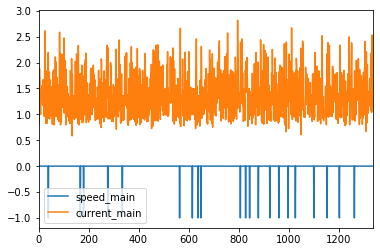

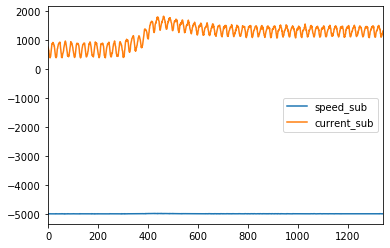

In [7]:
# plot both the main spindle and sub spindle current signals
df.plot(y=['speed_main','current_main'])
df.plot(y=['speed_sub','current_sub'])

You can see in the above, that tool 54 only works on the sub-spindle.

# 3.0 Label Each Cut

Now that we have the split data (stored in pickles) and the high level data with labels, we can label the split data. We will record this data in a low level CSV.

First, create the features that you want in the low-level dataframe (and subsequent CSV).

In [8]:
# define features that you want calculated on low_level_df
# format:
    # {"dictionary_key": [feature_function, "feature_name"]}

features = {"min_current_main":[feat_min_value, "current_main"],
            "max_current_main":[feat_max_value, "current_main"],
            "min_current_sub":[feat_min_value, "current_sub"],
            "max_current_sub":[feat_max_value, "current_sub"],
            "rms_current_main":[feat_rms_value, "current_main"],
            "rms_current_sub":[feat_rms_value, "current_sub"],
            "std_current_main": [feat_std_value, "current_main"], 
            "std_current_sub": [feat_std_value, "current_sub"],          
           }

In [9]:
# Create the high-level df
high_level = Path('high_level_LABELLED.csv')

df1 = pd.read_csv(high_level)
df1 = df1.dropna(subset=['failed']) # drop rows that do not have a failed indicator

# Create the low-level df
df2 = low_level_df(interim_data_folder, features,svd_feature=True, list_of_svd_signals=['current_sub', 'current_main'], svd_feat_count=10, svd_window_size=10)
df2.head()

,name_low,unix_date,date,tool,index,len_cut,min_current_main,max_current_main,min_current_sub,max_current_sub,...,svd_current_main_0,svd_current_main_1,svd_current_main_2,svd_current_main_3,svd_current_main_4,svd_current_main_5,svd_current_main_6,svd_current_main_7,svd_current_main_8,svd_current_main_9
0,1568211798_13_0,1568211798,2019-09-11 10:23:18,13,0,2907,284.000000,540.000000,1.000000,8.000000,...,54726.2,1164.52,1054.4,599.887,575.122,378.501,367.67,249.894,223.995,217.545
1,1568213830_36_5,1568213830,2019-09-11 10:57:10,36,5,203,0.764835,2.797824,220.898575,1127.567017,...,60.1239,6.22156,6.21507,6.07552,5.89093,5.63028,5.61173,5.28607,4.34098,3.07397
2,1568211798_3_1,1568211798,2019-09-11 10:23:18,3,1,227,189.000000,504.000000,1.000000,6.000000,...,16166.3,956.344,529.995,422.267,383.121,299.503,268.368,252.744,249.244,241.614
3,1568213830_21_0,1568213830,2019-09-11 10:57:10,21,0,916,289.078888,696.618896,0.284974,7.234311,...,36717.3,686.75,471.851,413.476,244.352,239.495,195.658,187.021,182.242,181.244
4,1540298755_54_0,1540298755,2018-10-23 08:45:55,54,0,1344,1.000000,5.000000,503.000000,1021.000000,...,179.53,26.2089,25.9756,25.8318,24.0378,23.1797,22.836,22.3296,22.1329,20.9512


Now we will label the low_level dataframe with the failure data that was recorded in the high_level.csv

In [10]:
# label the individual cuts in the low-level df as failed or not
df_low = check_date(df1, df2)

# save as a csv
df_low.to_csv(('low_level_LABELLED.csv'),index=False)
df_low.head()

,name_low,unix_date,date,tool,index,len_cut,min_current_main,max_current_main,min_current_sub,max_current_sub,...,svd_current_main_1,svd_current_main_2,svd_current_main_3,svd_current_main_4,svd_current_main_5,svd_current_main_6,svd_current_main_7,svd_current_main_8,svd_current_main_9,failed
0,1568211798_13_0,1568211798,2019-09-11 10:23:18,13,0,2907,284.000000,540.000000,1.000000,8.000000,...,1164.52,1054.4,599.887,575.122,378.501,367.67,249.894,223.995,217.545,
1,1568213830_36_5,1568213830,2019-09-11 10:57:10,36,5,203,0.764835,2.797824,220.898575,1127.567017,...,6.22156,6.21507,6.07552,5.89093,5.63028,5.61173,5.28607,4.34098,3.07397,
2,1568211798_3_1,1568211798,2019-09-11 10:23:18,3,1,227,189.000000,504.000000,1.000000,6.000000,...,956.344,529.995,422.267,383.121,299.503,268.368,252.744,249.244,241.614,
3,1568213830_21_0,1568213830,2019-09-11 10:57:10,21,0,916,289.078888,696.618896,0.284974,7.234311,...,686.75,471.851,413.476,244.352,239.495,195.658,187.021,182.242,181.244,
4,1540298755_54_0,1540298755,2018-10-23 08:45:55,54,0,1344,1.000000,5.000000,503.000000,1021.000000,...,26.2089,25.9756,25.8318,24.0378,23.1797,22.836,22.3296,22.1329,20.9512,
